## Feature Extraction: Neurophysiology [dyskinesia project]

This notebooks helps to extract features from preprocessed ECoG and LFP (STN electrodes) data within the ReTune-Dyskinesia project.

Data is required to be preprocessed, for example with the corresponding preprocess functions.

<b> Content </b>


<b> Periodic component analysis: </b> 
- Try Wavelet Dceomposition vs Welch (tapered) Spectral Decomposition



<b> Aperiodic estimates </b>
Relevant literature:
- Periodic and a-periodic components relevance and interaction, different reasons (per + a-per) for signal changes observed within a specific bandwidth. Aperiodic component (complicated) vs exponent (1/f) (Donoghue, ..., Shestyuk & Voytek, Nature Neurosc 2020 : https://www.nature.com/articles/s41593-020-00744-x)
- cycle-by-cycle features: bycycle toolbox (Cole & Voytek, J of Neurophys 2019, https://journals.physiology.org/doi/full/10.1152/jn.00273.2019)

### 0. Loading packages and functions, defining paths



In [527]:
# Importing Python and external packages
import os
import sys
import importlib
import json
from abc import ABCMeta, abstractmethod
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import ghostipy as gsp
from pacpy.pac import plv
from scipy import fftpack

#mne
import mne_bids
import mne


In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('mne_bids', mne_bids.__version__)
print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)
## FEB 2022:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
pandas 1.3.4
numpy 1.20.3
mne_bids 0.9
mne 0.24.1
sci-py 1.7.1
sci-kit learn 1.0.1


In [3]:
# define local storage directories
projectpath = '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'
codepath = os.path.join(projectpath, 'code')
pynmd_path = os.path.join(codepath, 'py_neuromodulation')
rawdatapath = '/Users/jeroenhabets/OneDrive - Charité - Universitätsmedizin Berlin/BIDS_Berlin_ECOG_LFP/rawdata'
proc_data_path = os.path.join(projectpath, 'data/preprocess')
# change working directory to project-code folder
os.chdir(codepath)
os.getcwd()

'/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code'

In [492]:

# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng

import lfpecog_preproc.preproc_filters as fltrs
# own data exploration functions
import lfpecog_features.feats_read_data as read_data
import lfpecog_exploration.expl_plotting as expl_plot

# import py_neuromodulation after defining relevant directories
from py_neuromodulation import nm_BidsStream, nm_analysis


### 1. Patient-Run Definition and Data Loading

#### Print available runs for subject and settings-version

In [512]:
# Explore available preprocessed runs
importlib.reload(read_data)
read_data.show_runs(
    sub='008',
    version='v1.1_Feb22',
    project_path=projectpath,
)


### SHOW RUNS ###
For subject 008, in preproc-version v1.1_Feb22 are available:

LFP_LEFT:
['008', 'EphysMedOn02', 'SelfpacedHandTapL', 'StimOffDopa60']
['008', 'EphysMedOn02', 'Rest', 'StimOffDopa50']
['008', 'EphysMedOn02', 'Rest', 'StimOffDopa10']
['008', 'EphysMedOn02', 'SelfpacedHandTapL', 'StimOffDopa35']
['008', 'EphysMedOn02', 'Rest', 'StimOffDopa00']
['008', 'EphysMedOn02', 'SelfpacedHandTapL', 'StimOffDopa15']
['008', 'EphysMedOn02', 'Rest', 'StimOffDopa30']
['008', 'EphysMedOn02', 'Free', 'StimOffDopa20']
['008', 'EphysMedOn02', 'Free', 'StimOffDopa55']

LFP_RIGHT:
['008', 'EphysMedOn02', 'Rest', 'StimOffDopa10']
['008', 'EphysMedOn02', 'Rest', 'StimOffDopa50']
['008', 'EphysMedOn02', 'SelfpacedHandTapL', 'StimOffDopa15']
['008', 'EphysMedOn02', 'SelfpacedHandTapL', 'StimOffDopa60']
['008', 'EphysMedOn02', 'Free', 'StimOffDopa55']
['008', 'EphysMedOn02', 'Free', 'StimOffDopa20']
['008', 'EphysMedOn02', 'Rest', 'StimOffDopa00']
['008', 'EphysMedOn02', 'Rest', 'StimOffDopa30'

#### Select and Load in runs to explore


Not defining task, acquisition or group results in selecting all available options

In [513]:
# Select runs to explore/ ft-extract
importlib.reload(read_data)
fsel, groups, fdir = read_data.select_runs(
    sub='008',
    version='v1.0_Feb22',
    project_path=projectpath,
    sess_incl=['EphysMedOn02'],
    tasks_incl=['Rest', 'SelfpacedHandTapL'],
    # acqs_incl=[
    #     'StimOffDopa00',
    #     'StimOffDopa10',
    #     'StimOffDopa30',
    #     'StimOffDopa50',
    # ],
    groups_incl=['LFP_RIGHT', 'LFP_LEFT'],  # if not given, all groups are included
)

In [514]:
# print and check selected runs
fsel

['008_EphysMedOn02_Rest_StimOffDopa00_1_v1.0_Feb22_LFP_RIGHT_PREPROC_data.npy',
 '008_EphysMedOn02_SelfpacedHandTapL_StimOffDopa35_1_v1.0_Feb22_LFP_RIGHT_PREPROC_data.npy',
 '008_EphysMedOn02_Rest_StimOffDopa30_1_v1.0_Feb22_LFP_RIGHT_PREPROC_data.npy',
 '008_EphysMedOn02_Rest_StimOffDopa00_1_v1.0_Feb22_LFP_LEFT_PREPROC_data.npy',
 '008_EphysMedOn02_SelfpacedHandTapL_StimOffDopa35_1_v1.0_Feb22_LFP_LEFT_PREPROC_data.npy',
 '008_EphysMedOn02_SelfpacedHandTapL_StimOffDopa60_1_v1.0_Feb22_LFP_RIGHT_PREPROC_data.npy',
 '008_EphysMedOn02_SelfpacedHandTapL_StimOffDopa15_1_v1.0_Feb22_LFP_RIGHT_PREPROC_data.npy',
 '008_EphysMedOn02_Rest_StimOffDopa10_1_v1.0_Feb22_LFP_LEFT_PREPROC_data.npy',
 '008_EphysMedOn02_Rest_StimOffDopa30_1_v1.0_Feb22_LFP_LEFT_PREPROC_data.npy',
 '008_EphysMedOn02_Rest_StimOffDopa50_1_v1.0_Feb22_LFP_RIGHT_PREPROC_data.npy',
 '008_EphysMedOn02_SelfpacedHandTapL_StimOffDopa15_1_v1.0_Feb22_LFP_LEFT_PREPROC_data.npy',
 '008_EphysMedOn02_Rest_StimOffDopa10_1_v1.0_Feb22_LFP_RIGHT

In [515]:
# Create dataclass per session
# session-dataclass wil contain dict with dataclasses containing
# data per run
importlib.reload(read_data)
sub8_On2 = read_data.SessionData(fsel, fdir)


In [196]:
'''CREATE CLASS WITH DATA

- WINDOWING (1024 SAMPLES?)
- ADDITIONAL FILTERING BEFORE WINDOWING!

- CLASSES WITH FILTERED WINDOWED SIGNALS

'''

(4, 819)

### 2. Explore spectral domain

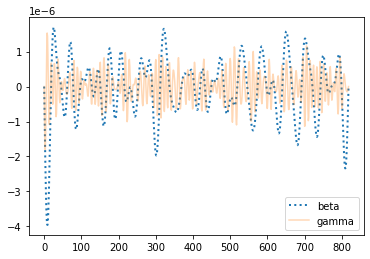

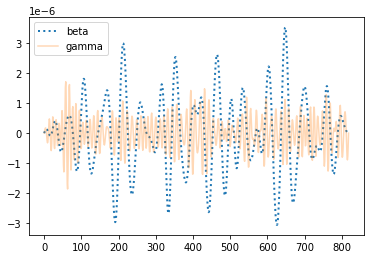

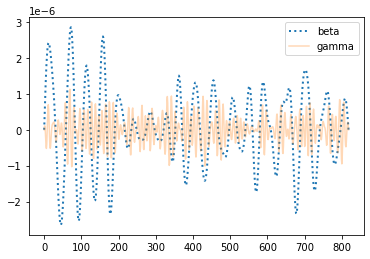

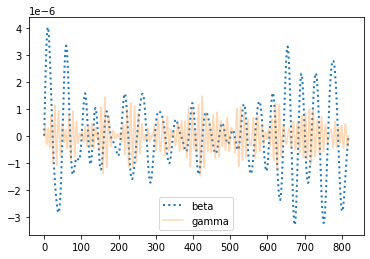

In [239]:

for w in [50, 100, 150, 200,]:
    sel = np.hstack(tempdat['50']['lfp_left'][w:w+2, 1:, :])
    sel = tempdat['50']['lfp_left'][w, 1:, :]
    for s in range(sel.shape[0])[2:3]:
        B = mne.filter.filter_data(sel[s, :], sfreq=800, l_freq=13, h_freq=30, verbose=False)
        plt.plot(B, label='beta', lw=2, ls='dotted')
        G = mne.filter.filter_data(sel[s, :], sfreq=800, l_freq=60, h_freq=90, verbose=False)
        plt.plot(G, label='gamma', alpha=.3)
        G[np.angle(signal.hilbert(B)) > -np.pi*.5] = 0

        plt.legend()
        # coh = signal.coherence(x=B, y=G, fs=800,)
        # pac = plv(B, G, (48, 50), (100, 102))
        # print(w, pac)  # -> tensorpac
    # plt.xscale('log')
    # plt.xlim(0, 100)
    plt.show()

In [62]:
# 4000 Hz window len (msec) for 800 Hz win len of 1024 samples
1 / 800 * 1024 * 1000

1280.0

In [249]:
fileDict

{2: {'sub': '008',
  'ses': 'EphysMedOn02',
  'task': 'Rest',
  'acq': 'StimOffDopa30',
  'run': '1',
  'projpath': '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys',
  'version': 'v0.6_Feb22'},
 7: {'sub': '008',
  'ses': 'EphysMedOn02',
  'task': 'Rest',
  'acq': 'StimOffDopa00',
  'run': '1',
  'projpath': '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys',
  'version': 'v0.6_Feb22'},
 9: {'sub': '008',
  'ses': 'EphysMedOn02',
  'task': 'Rest',
  'acq': 'StimOffDopa10',
  'run': '1',
  'projpath': '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys',
  'version': 'v0.6_Feb22'},
 10: {'sub': '008',
  'ses': 'EphysMedOn02',
  'task': 'Rest',
  'acq': 'StimOffDopa50',
  'run': '1',
  'projpath': '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys',
  'version': 'v0.6_Feb22'}}

In [437]:
g = 'lfp_left'
c = 2
chname = tempnms['00'][g][c]
win = 200
data00 = tempdat['00'][g]
data50 = tempdat['50'][g]
# ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
#                         sig,
#                         fs=Fs,
#                         freq_limits=[1,100],  # [flim[0], flim[1]]
#                     )
# ghs_psd = np.abs(ghs_cfs)**2 / Fs
# ghs_psd /= np.max(ghs_psd)  # normalisation

In [466]:
def normalize(data, meth: str):
    '''
    Arguments:
        - 3d array [windows, rows, time]
        - meth: method: nrm or std: 
        normalization
            [min - max] = [0 - 1];
        standardization
            [-2sd, +2sd] = [-2, 2]
    '''
    for w in range(data.shape[0]):
        if meth == 'std':
            m = np.nanmean(data[w, :, :])
            s = np.nanstd(data[w, :, :])
            data[w, :, :] = (data[w, :, :] - m) / s
        elif meth == 'nrm':
            mx = np.nanmax(data[w, :, :])
            data[w, :, :] = data[w, :, :] / mx

    return data

### 3. Explore spectral plots

(512, 100)


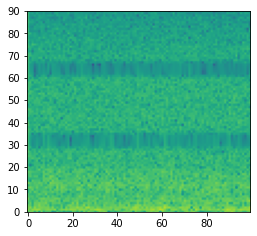

In [292]:
nseg = 512

dat = sub8_On2.runs['Rest_StimOffDopa00'].lfp_left_arr[2, :100 * nseg]
slices = np.reshape(dat, newshape=(len(dat) // nseg, nseg))
slices = slices.T  # every 1024 slice is one column

spectrum = np.fft.fft(slices, axis=0)
print(spectrum.shape)
S = np.abs(spectrum)
S = np.log(S)
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.imshow(S, origin='lower', cmap='viridis',)
ax.set_ylim(0,90)
plt.show()

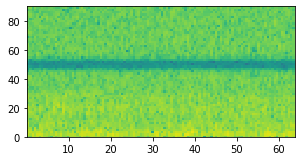

In [291]:
freqs, times, Sx = signal.spectrogram(dat, fs=800, window='hanning',
                                      nperseg=nseg, #noverlap=512,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(4.8, 2.4))
ax.pcolormesh(times, freqs, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylim(0,90)

plt.show()

In [477]:
sub8_On2.runs['Rest_StimOffDopa00'].lfp_right_arr[5, :]

array([ 2.00702596e-05, -1.92848032e-05,  1.77781204e-05, ...,
       -4.19016196e-03, -3.14783906e-03, -1.49891597e-03])

In [528]:
sub8_On2.runs_incl

['Rest_StimOffDopa00',
 'SelfpacedHandTapL_StimOffDopa35',
 'Rest_StimOffDopa30',
 'SelfpacedHandTapL_StimOffDopa60',
 'SelfpacedHandTapL_StimOffDopa15',
 'Rest_StimOffDopa10',
 'Rest_StimOffDopa50']

In [532]:
sub8_On2.runs['Rest_StimOffDopa00'].sub

'008'

In [534]:
importlib.reload(expl_plot)
expl_plot.electrode_spectral_check(
    sessionClass=sub8_On2,
    savedir=os.path.join(
        projectpath, 'figures', 'TEMP', 'spectral_tests'
    ),
    sides=['lfp_left', 'lfp_right'],  # add optionality for one column fig!
)

'Figure saved!'

In [ ]:
ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
        sig,
        fs=Fs,
        freq_limits=[1, 120]  # [flim[0], flim[1]]
    )
    ghs_psd = np.abs(ghs_cfs)**2 / Fs
    # alt psd calc: hgs_cfs.real**2 + ghs_cfs.imag**2
    ghs_psd /= np.max(ghs_psd)  # normalisation
    axes[0].pcolormesh(time, ghs_f, ghs_psd, cmap='viridis')
    axes[0].set_title('Ghostipy Cont. Wavelet Transform')

    # scipy CWT
    w = 8  # depth/spaces?
    scp_f = np.linspace(1, Fs / 2, 100)
    widts = (Fs * w) / (2 * scp_f * np.pi)
    # mor = signal.morlet2(M=100, s=4, w=2)
    scp_cfs = signal.cwt(sig, signal.morlet2, widths=widts, w=w, dtype='complex128')
    scp_psd = np.abs(scp_cfs)
    scp_psd /= np.max(scp_psd)  # normalisation
    axes[1].pcolormesh(time, scp_f, scp_psd, cmap='viridis')
    axes[1].set_title('SciPy Cont. Wavelet Transform')

    # scipy spectrogram
    npseg = 256
    fft_f, fft_t, fft_psd = signal.spectrogram(
        sig, fs=Fs, nperseg=npseg
    )  # or welch
    fft_t = time[(fft_t * len(time)).astype(int)]
    axes[2].pcolormesh(fft_t, fft_f, fft_psd)
    axes[2].set_title('SciPy Spectrogram (FFT)')

In [543]:
g = 'lfp_left'
c = 2
chname = tempnms['00'][g][c]

data00 = tempdat['00'][g]
# data10 = tempdat['10'][g]
# data30 = tempdat['30'][g]
# data50 = tempdat['50'][g]
norm = 'std'

# for nrm in ['std', 'nrm', 'LOG']:
nrm = 'std'
for dff in ['minus', '%Change']:  # 
    plot_spectral_course(
        basedata=data00,
        dopa_data_dict=tempdat,
        dopa_names=tempnms['00'],
            dopa_keys=[ '50',],  #'10', '30',
            group=g,
            ch=c,
            norm=nrm,
            diff=dff,
        )


        ### WHY BETA INCREASE IN LOG VERSION??!!!


In [541]:
def plot_spectral_course(
    basedata, dopa_data_dict, dopa_names, dopa_keys: list,
    group: str, ch: int, norm: str, diff: str,
):
    '''
    Plot spectral differences between session and baseline session.
    '''
    chname = dopa_names[group][ch]

    fig,axes = plt.subplots(
        len(dopa_keys), 3,
        sharey='row', sharex='col',
        figsize=(10, 6 * len(dopa_keys)))
    axes = axes.flatten()
    for row, dopaXX in enumerate(dopa_keys):
        dopadata = dopa_data_dict[dopaXX][group]

        for w in range(basedata.shape[0] // 10):
            d = np.hstack(basedata[w * 10:(w * 10) + 10, ch, :])
            f, t, ps = signal.spectrogram(
                d, fs=800, nperseg=256,
            )
            if w == 0:
                basepsd = np.empty((
                    basedata.shape[0] // 10,
                    len(f),
                    len(t),
                ))
            basepsd[w, :, :] = ps

        if nrm != 'LOG': basepsd = normalize(basepsd, norm)
        if nrm == 'LOG': basepsd = np.log(basepsd)
        basemean = np.nanmean(basepsd, axis=0)
        # Plot base (col-0)
        if nrm == 'LOG':
            im = axes[row * 3 + 0].pcolormesh(
                t, f, basemean, cmap='viridis', vmin=-35, vmax=-30,)
        elif nrm == 'std':
            im = axes[row * 3 + 0].pcolormesh(
                t, f, basemean, cmap='viridis', vmin=0, vmax=4,)
        else:
            im = axes[row * 3 + 0].pcolormesh(t, f, basemean, cmap='viridis')
        fig.colorbar(im, ax=axes[row * 3 + 0], )
        axes[row * 3 + 0].set_title('BASE')
        axes[row * 3 + 0].set_ylabel(f'Freq (Hz, {norm})')

        dopapsd = np.empty((
                    dopadata.shape[0] // 10,
                    len(f),
                    len(t),
                ))
        for w in range(dopapsd.shape[0]):
            d = np.hstack(dopadata[w * 10:(w * 10) + 10, ch, :])
            f, t, ps = signal.spectrogram(
                d, fs=800, nperseg=256)
            dopapsd[w, :, :] = ps
        if nrm != 'LOG': dopapsd = normalize(dopapsd, norm)
        if nrm == 'LOG': dopapsd = np.log(dopapsd)
        dopamean = np.nanmean(dopapsd, axis=0)
        # plot DOPA, col-1
        if nrm == 'LOG':
            im = axes[row * 3 + 0].pcolormesh(
                t, f, dopamean, cmap='viridis', vmin=-35, vmax=-30,)
        elif nrm == 'std':
            im = axes[row * 3 + 1].pcolormesh(
                t, f, dopamean, cmap='viridis', vmin=0, vmax=4,)
        else:
            im = axes[row * 3 + 1].pcolormesh(t, f, dopamean, cmap='viridis')
        fig.colorbar(im, ax=axes[row * 3 + 1], )
        axes[row * 3 + 1].set_title(f'DOPA {dopa_keys[row]}')

        # DIFF
        if diff[0] == '%':  # define plot limits
            if nrm == 'LOG':
                powlims = (-5, 5)
            else:
                powlims = (-200, 200)
        elif nrm == 'LOG':
            powlims = (-1, 1)
        else:
            if norm == 'nrm':
                powlims = (-.1, .1)
            elif norm == 'std':
                powlims = (-3, 3)
        if diff == 'minus': psdiff = dopapsd - basemean
        if diff == '%Change': psdiff = ((dopapsd / basemean) * 100) - 100
        psdiff = np.nanmean(psdiff, axis=0)
        im = axes[row * 3 + 2].pcolormesh(t, f, psdiff,
            cmap='coolwarm', vmin=powlims[0], vmax=powlims[1])
        fig.colorbar(im, ax=axes[row * 3 + 2], )
        axes[row * 3 + 2].set_title(f'DIFF ({diff})')

        # all plots
        for ax in axes:
            ax.set_ylim(0, 100)
            ax.set_xlabel('Time (sec)')

    plt.suptitle(f'{RunInfo.store_str} ({group}: {chname})',
                c='gray', alpha=.5, y=.99, x=.4)
    plt.tight_layout(w_pad=.05)
    plt.savefig(os.path.join(spec_fig,
                f'SPEC_TEST_00vs{dopa_keys}_{norm}_{diff}'),
                facecolor='white', dpi=150)
    plt.close()


In [424]:
pd.DataFrame(psdiff).describe()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,11.338391,230.777068,1.730689,-36.526793,25.217338,19.648497,9.333329,6.386118,1.136534,11.150465,...,-137.809805,8.493589,-1.575030,9.986192,13.849771,-65.049606,10.310639,-1.052715,-5.182092,10.754419
std,65.031270,1830.850918,46.137900,681.147310,119.234502,161.103864,64.829212,41.966471,72.460560,136.606070,...,1649.197910,61.878133,84.355342,66.570767,57.173457,893.983519,42.550590,98.878356,80.808166,57.111369
min,-214.746070,-175.174992,-233.425535,-7322.934606,-251.777062,-529.317798,-384.695062,-204.853201,-744.913064,-641.556306,...,-18717.328824,-244.786409,-609.266911,-470.858066,-214.815553,-10124.247438,-142.779837,-763.495852,-564.489765,-345.774088
25%,15.535429,14.562407,14.005507,15.451850,15.586630,15.837505,15.725187,15.680995,13.382596,14.749264,...,15.484896,14.861358,15.204023,15.384578,15.667523,15.740849,13.658483,15.030008,13.898907,15.742409
50%,15.890705,15.890651,15.890641,15.894880,15.890733,15.890734,15.890712,15.896433,15.890439,15.890519,...,15.890726,15.890569,15.890723,15.809812,15.890732,15.890733,15.800430,15.890689,15.890560,15.890723
75%,15.890755,15.890755,15.890755,15.895808,15.890755,15.890755,15.890755,15.898225,15.890755,15.890755,...,15.890755,15.890755,15.890755,15.856090,15.890755,15.890755,15.860461,15.890755,15.890755,15.890755
max,420.370039,17877.932533,153.251521,1937.059574,1071.750687,1678.177767,330.768509,117.748807,88.281555,1293.917125,...,126.798516,439.881128,103.218793,205.991854,349.876839,242.894342,209.298387,418.124020,137.557715,224.012386


In [369]:
spec_fig = os.path.join(projectpath, 'figures', 'TEMP', 'spectral_tests')
os.mkdir(spec_fig)

In [269]:
importlib.reload(expl_plot)
importlib.reload(fltrs)

Fs = 800

# Read in Preprocessed Data
for n in [7, 10]:  # fileDict
    RunInfo = dataMng.RunInfo(
        sub=fileDict[n]['sub'],
        ses=fileDict[n]['ses'],
        task=fileDict[n]['task'],
        acq=fileDict[n]['acq'],
        run=fileDict[n]['run'],
        raw_path='',
        project_path=fileDict[n]['projpath'],
        preproc_sett=fileDict[n]['version'],
    )
    print(f'start: {RunInfo.acq}')

# PM: change later fig-folder-structure
    data, names = dataMng.read_preprocessed_data(RunInfo)
    fig_path_expl = (f'{projectpath}/figures/exploration/'
                    f'sub-{RunInfo.sub}/{RunInfo.store_str}'
                    f'/{RunInfo.preproc_sett}')
    temp_save = f'{projectpath}/figures/TEMP/{RunInfo.store_str}'
    if not os.path.exists(temp_save): os.mkdir(temp_save)

    n_wins = 30

    mean=True
    diff=True

    # Plot Wavelet Decomp
    max_chs = max([data[g].shape[1] for g in data])  # largest ch-number
    fig, axes = plt.subplots(
        max_chs - 1, len(data), figsize=(12, 16), sharex='row',
        sharey='col',)
    for ax, g in enumerate(data):
        if g[-4:] != 'left': print('skip', g)
        if g[-4:] != 'left': continue
        for n, ch in enumerate(names[g][2:3]):  # select LESS CHANNELS FOR TIME
            if ch == 'time':
                print('skip time row')
                continue
            elif n in [1, 4, 5, 6]:
                print(ch,'skipped bcs of time')
                continue
            print('start',ax, g, n, ch)
            if mean:
                full_wins = data[g].shape[0] // n_wins
                for wstart in np.arange(full_wins):
                    sig = np.hstack(
                        data[g][n_wins * wstart:n_wins * (wstart + 1),
                                n,
                                :,]
                    )
                    ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
                        sig,
                        fs=Fs,
                        freq_limits=[1,100],  # [flim[0], flim[1]]
                    )
                    ghs_psd = np.abs(ghs_cfs)**2 / Fs
                    ghs_psd /= np.max(ghs_psd)  # normalisation
                    if wstart == 0:  # create once 3d array to store psds
                        
                        psds = np.empty((full_wins,
                                         ghs_psd.shape[0],
                                         ghs_psd.shape[1]
                        ))
                        if RunInfo.acq[-2:] == '00':  # putted to hijack first win00 as base
                            print('defining baseline 00')
                            BASE_psd = ghs_psd.copy()
                            print(BASE_psd.shape)

                    psds[wstart, :, :] = ghs_psd  # one 2d array per 30-wins
                print('psds',psds.shape)
                if diff:
                    # if RunInfo.acq[-2:] == '00':  # DEFINE BASELINE
                    #     cfs_BASE, _, base_f, base_t, _ = gsp.cwt(
                    #         np.hstack(data[g][:, n, :])[:],
                    #         fs=Fs,
                    #         freq_limits=[1,100],
                    #     )
                    #     BASE_psd = np.abs(cfs_BASE)**2 / Fs
                    #     BASE_psd /= np.max(BASE_psd)
                        ### FIRST NORM AGAINST BASELINE, THEN AVERAGE WIN'S
                        # TODO: PLOT THE CHANGING REST FREQ'S OVER TIME,
                        # NORM AGAINST 30 SEC'S OF DOPA00
                        # THEN PLOT REST-CWT OVER TIME (PER 30 S, MEAN OVER 5 MINUTES?)
                    for w in range(psds.shape[0]):
                        psds[w, :, :] = (psds[w, :, :] / BASE_psd * 100) - 100  # extract the baseline cwt matrix
                        print('correct', ax, ch, w)
                        print(sum(sum(psds[w, :, :])))
                ghs_psd = np.nanmean(psds, axis=0)  # mean over all psd arrays
                print('psds new shape', ghs_psd.shape)
            else:
                sig = np.hstack(data[g][:n_wins, n, :])  # try out with 10 sec's
                ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
                    sig,
                    fs=Fs,
                    freq_limits=[1,100]  # [flim[0], flim[1]]
                )
                ghs_psd = np.abs(ghs_cfs)**2 / Fs
                # alt psd calc: hgs_cfs.real**2 + ghs_cfs.imag**2
                ghs_psd /= np.max(ghs_psd)  # normalisation
            
            # Plot
            colormap='viridis'
            if diff: colormap='coolwarm'
            im = axes[n - 1, ax].pcolormesh(
                ghs_t, ghs_f, ghs_psd, cmap=colormap, )  #vmin=-1, vmax=1,
            axes[n - 1, ax].set_title(ch)
            if ax == 0: axes[n - 1, ax].set_ylabel('Frequency (Hz)')
            fig.colorbar(im, ax=axes[n - 1, ax])
        axes[max_chs - 2, ax].set_xlabel('Time (sec)')
    plotname = f'{RunInfo.store_str}_({n_wins}_wins)'
    if mean: plotname = f'{RunInfo.store_str}_({n_wins}_wins_mean)'
    if diff: plotname += '_(%DIFF vs 3min-Dopa00)'
    print(f'saving {RunInfo.store_str}, name: {plotname}')
    plt.suptitle(f'Continuous Wavelet Transform (ghostipy): {plotname}',
                 size=14, x=.35, y=.99,)
    plt.tight_layout(h_pad=.05)
    
    plt.savefig(os.path.join(temp_save, f'CWT_{plotname}'),
                dpi=150, facecolor='white',)
    plt.close()


    # for nseg in [256, 512, ]:
    #     print('start ', nseg)
    #     expl_plot.meanPSDs_session_channels(
    #     data, names, norm='norm', nseg=nseg, RunInfo=RunInfo,
    #     save=temp_save, plot=False)

start: StimOffDopa00
skip ecog
start 1 lfp_left 0 LFP_L_1_2
(67, 24570)
psds (19, 67, 24570)
correct 1 LFP_L_1_2 0
correct 1 LFP_L_1_2 1
correct 1 LFP_L_1_2 2
correct 1 LFP_L_1_2 3
correct 1 LFP_L_1_2 4
correct 1 LFP_L_1_2 5
correct 1 LFP_L_1_2 6
correct 1 LFP_L_1_2 7
correct 1 LFP_L_1_2 8
correct 1 LFP_L_1_2 9
correct 1 LFP_L_1_2 10
correct 1 LFP_L_1_2 11
correct 1 LFP_L_1_2 12
correct 1 LFP_L_1_2 13
correct 1 LFP_L_1_2 14
correct 1 LFP_L_1_2 15
correct 1 LFP_L_1_2 16
correct 1 LFP_L_1_2 17
correct 1 LFP_L_1_2 18
psds new shape (67, 24570)
skip lfp_right
saving 008_EphysMedOn02_Rest_StimOffDopa00_1, name: 008_EphysMedOn02_Rest_StimOffDopa00_1_(30_wins_mean)_(%DIFF vs 3min-Dopa00)
start: StimOffDopa50
skip ecog
start 1 lfp_left 0 LFP_L_1_2
psds (8, 67, 24570)
correct 1 LFP_L_1_2 0
correct 1 LFP_L_1_2 1
correct 1 LFP_L_1_2 2
correct 1 LFP_L_1_2 3
correct 1 LFP_L_1_2 4
correct 1 LFP_L_1_2 5
correct 1 LFP_L_1_2 6
correct 1 LFP_L_1_2 7
psds new shape (67, 24570)
skip lfp_right
saving 008_E

In [ ]:
for g in data:
    print(g, 'start highpass 60')
    data[g] = fltrs.bp_filter(
        data[g],
        sfreq=800,
        l_freq=60,
        h_freq=None,)
    print(g, 'start low pass 90')
    data[g] = fltrs.bp_filter(
        data[g],
        sfreq=800,
        l_freq=None,
        h_freq=90,)

In [17]:
# import single data file
sub = '009'
ses = 'EcogLfpMedOn02'
task = 'Rest'
acq = 'StimOff'
run = '01'
raw_path = ''
project_path = projectpath
sett_version = 'v0.4_Feb22'

In [722]:
importlib.reload(dataMng)
runInfo = dataMng.RunInfo(
    sub, ses, task, acq, run,
    raw_path, project_path, sett_version,
)

### TODO: CHANGE FIG + DATA PATHS IN PREPROCESS FIG AND DATA
levdata, levnames = dataMng.read_preprocessed_data(runInfoLevels)
# make data class (data, names, fig_path)

In [34]:
importlib.reload(dataMng)
importlib.reload(expl_plot)


for n in fileDict:
    RunInfo = dataMng.RunInfo(
        sub=fileDict[n]['sub'],
        ses=fileDict[n]['ses'],
        task=fileDict[n]['task'],
        acq=fileDict[n]['acq'],
        run=fileDict[n]['run'],
        raw_path='',
        project_path=fileDict[n]['projpath'],
        preproc_sett=fileDict[n]['version'],
    )
    print(f'\nSTART: {RunInfo.store_str}\n')

# PM: change later fig-folder-structure
    data, names = dataMng.read_preprocessed_data(RunInfo)
    fig_path_expl = (f'{projectpath}/figures/exploration/'
                    f'sub-{RunInfo.sub}/{RunInfo.store_str}'
                    f'/{RunInfo.preproc_sett}')
    # Plot
    for nseg in [256, 512, 800]:
        expl_plot.meanPSDs_session_channels(
        data, names, norm='norm', nseg=nseg, RunInfo=RunInfo,
        save=fig_path_expl, plot=False)


START: 009_EcogLfpMedOn02_SelfpacedHandFlipL_StimOffDopa50_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch

START: 009_EcogLfpMedOn02_Free_StimOffDopa55_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch

START: 009_EcogLfpMedOn02_Rest_StimOffDopa65_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
START lfp_left with welch
START lfp_right with welch

START: 009_EcogLfpMedOn02_SelfpacedHandFlipR_StimOffDopa70_1

START ecog with welch
START lfp_left with welch
START lfp_right with welch
START ecog with welch
STAR

work according to contacts; visualize different contacts (and sources) over time and states; then choose how to prceed

### py_neuromodulation functionality

In [ ]:
pn_stream = nm_BidsStream.BidsStream(PATH_RUN=pathrun,
    PATH_BIDS=pathbidsraw,
    PATH_OUT=pathout)
pn_stream.settings

## Spectral Exploration

In [366]:
dat = data['ecog']
nms = names['ecog']
sig = dat[110, 3, :]
time = dat[110, 0, :]

In [456]:
winsum = 5
np.arange(0, dat.shape[0] // winsum * winsum, winsum)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295])

In [460]:
def time2spectral(
    data, method: str, Fs: int=800,
):
    '''Timeit cwt via scipy and ghostipy'''
    ch = 3

    if method == 'ghostipy':
        winsum = 5
        startw = np.arange(
            0,
            data.shape[0] // winsum * winsum,
            winsum
        )
        for n, w in enumerate(startw):
            sig = np.hstack((
                data[w:w + winsum, ch, :]
            ))

        # for w in np.arange(data.shape[0]):
        #     sig = data[w, ch, :]

            ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
                sig,
                fs=Fs,
                freq_limits=[1, 120]  # [flim[0], flim[1]]
            )
            if w == 0:  # create empty array with nr new freqs
                specArr = np.zeros((  # 4-dimensional
                    data.shape[1] - 1,  # number of channels
                    data.shape[0] // winsum,  # windows
                    len(ghs_f),  # new freq's
                    ghs_cfs.shape[1],  # over time
                ))
            ghs_psd = np.abs(ghs_cfs)**2 / Fs
            specArr[ch, n, :, :] = ghs_psd
        

        

    return specArr, ghs_f

In [461]:
spc3 = time2spectral(dat, method='ghostipy')
# one channel, 300 x 800 (5 min's) -> 8 min

In [ ]:
spc  # ch2 ecog
gf  # freqs


In [435]:
time10 = np.hstack((dat[:10, 0, :]))
c2_10w = np.hstack((spc[2, :10, :, :]))

In [402]:
def compareCWT(sig, time, Fs=800, flim=(4, 90)):

    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

    # ghostipy: https://github.com/kemerelab/ghostipy/blob/master/ghostipy/spectral/cwt.py
    # uses default Morse wavelet
    ghs_cfs, _, ghs_f, ghs_t, _ = gsp.cwt(
        sig,
        fs=Fs,
        freq_limits=[1, 120]  # [flim[0], flim[1]]
    )
    ghs_psd = np.abs(ghs_cfs)**2 / Fs
    # alt psd calc: hgs_cfs.real**2 + ghs_cfs.imag**2
    ghs_psd /= np.max(ghs_psd)  # normalisation
    axes[0].pcolormesh(time, ghs_f, ghs_psd, cmap='viridis')
    axes[0].set_title('Ghostipy Cont. Wavelet Transform')

    # scipy CWT
    w = 8  # depth/spaces?
    scp_f = np.linspace(1, Fs / 2, 100)
    widts = (Fs * w) / (2 * scp_f * np.pi)
    # mor = signal.morlet2(M=100, s=4, w=2)
    scp_cfs = signal.cwt(sig, signal.morlet2, widths=widts, w=w, dtype='complex128')
    scp_psd = np.abs(scp_cfs)
    scp_psd /= np.max(scp_psd)  # normalisation
    axes[1].pcolormesh(time, scp_f, scp_psd, cmap='viridis')
    axes[1].set_title('SciPy Cont. Wavelet Transform')

    # scipy spectrogram
    npseg = 256
    fft_f, fft_t, fft_psd = signal.spectrogram(
        sig, fs=Fs, nperseg=npseg
    )  # or welch
    fft_t = time[(fft_t * len(time)).astype(int)]
    axes[2].pcolormesh(fft_t, fft_f, fft_psd)
    axes[2].set_title('SciPy Spectrogram (FFT)')

    # plot makeup
    for ax in axes:
        ax.set_ylim(flim[0], flim[1])
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlabel('Time (sec)')

    plt.show()

    return ghs_psd, ghs_f, scp_psd, scp_f

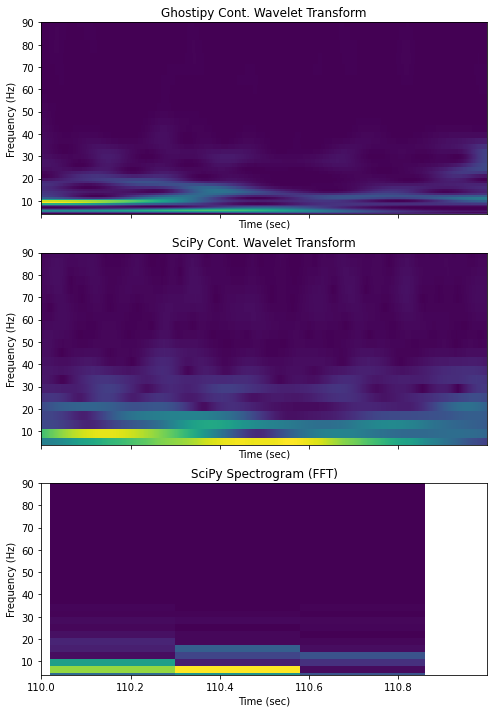

In [408]:
sig = dat[110, 2, :]
gpsd, gf, scpsd, scf = compareCWT(sig, time)

START ecog with welch
START lfp_left with welch
START lfp_right with welch


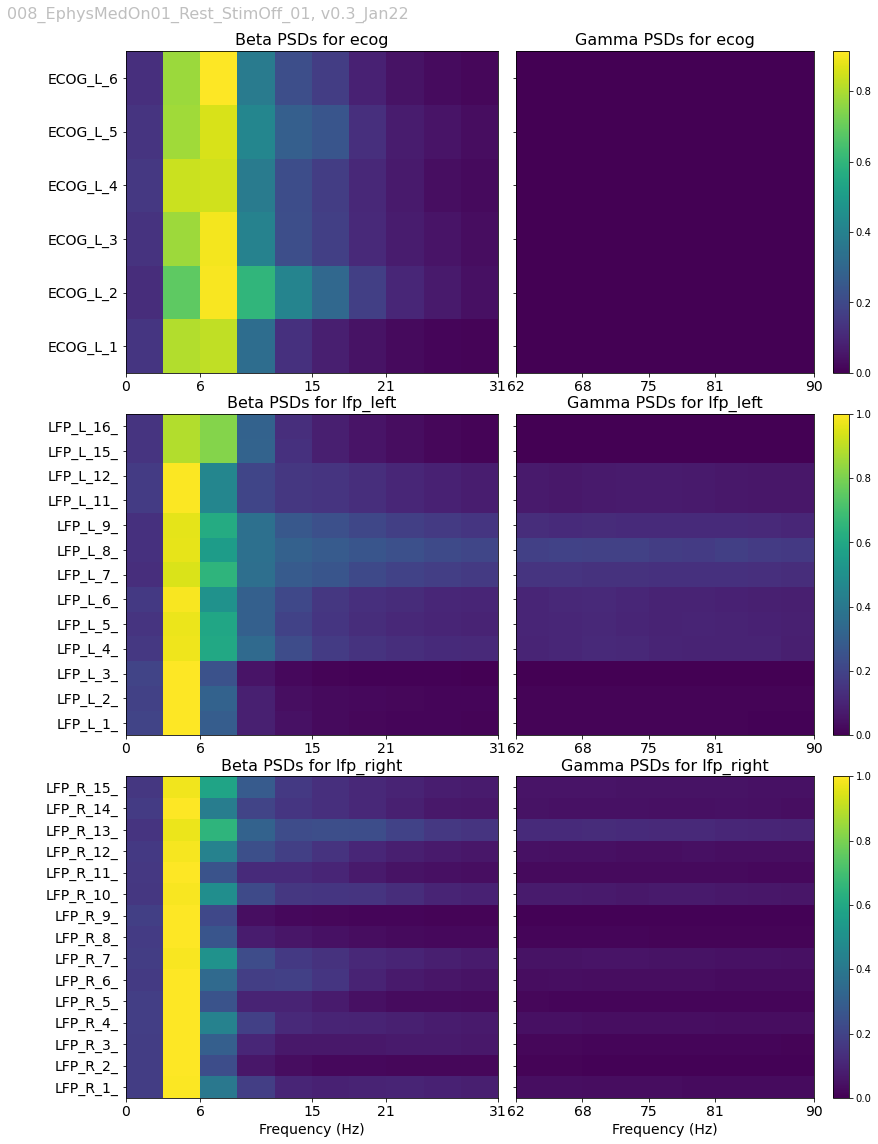

In [757]:
# Plot PSD (beta-gamma) Channel-Overview per Session
expl_plot.meanPSDs_session_channels(
    data, names, norm='norm', nseg=256, RunInfo=runInfo,
    save=fig_path_seg)

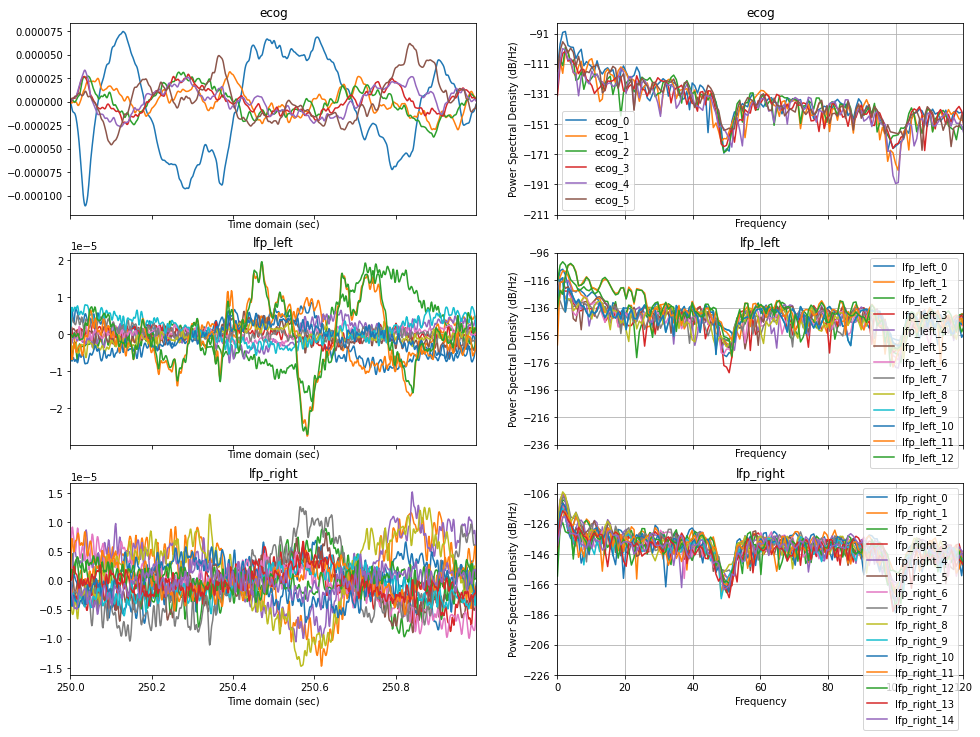

In [494]:
fig, axes = plt.subplots(len(data), 2, sharex='col', figsize=(16,12))
w = 250
for n, g in enumerate(data):
    x = data[g][w, 0, :].T
    y = data[g][w, 1:, :].T
    # Raw
    axes[n, 0].plot(x, y)
    axes[n, 0].set_xlabel('Time domain (sec)')
    axes[n, 0].set_title(g)
    axes[n, 0].set_xlim(x[0], x[-1])
    # PSD
    for s in np.arange(y.shape[1]):
        axes[n, 1].psd(y[:, s], NFFT=1024, Fs=800, label=f'{g}_{s}')
    axes[n, 1].set_xlim(0, 120)
    axes[n, 1].set_title(g)
    axes[n, 1].legend()

plt.show()


### 2. Settings of Feature Extraction ??

In [351]:
# APERIODIC EXPONENT
from fooof import FOOOF  # https://fooof-tools.github.io/fooof/

# cycle-by-cyle estimates
# neurodsp == 1.0.0  # install/import
# # neurodsp is a toolbox for digital signal processing for neural time series
# bycycle == 0.1.3  # install/import
# # bycycle is a toolbox for cycle-by-cycle analyses of neural oscillations

In [79]:
f, psd = signal.welch(
x=ecog250[3][0:125],
fs=250,
window='hann',
nperseg=125,
noverlap=None,
nfft=F,
)

psd.shape

(513,)

In [95]:
## Wavelet Decomposition
power = mne.time_frequency.tfr_morlet(
    epochs, 
    freqs=freqs, 
    n_cycles=n_cycles, 
    return_itc=False, 
    picks='ecog', 
    n_jobs=-1
)

(513,)
(1026,)
(4, 513)
(513,)


#### Pro Memori: Annotations and Events

In [ ]:
# check:
events, event_id = mne.events_from_annotations(raw, event_id={"EMG_onset": 1})
epochs = mne.Epochs(raw, events=events, tmin=-5, tmax=5, baseline=None)

#### - Feature extraction and visualization

In [ ]:
freqs = np.arange(1, 100)
n_cycles = 5

#### Pro Memori: Involve py_neuromodulation-functions in Signal Analysis